# About Dataset


## Context


There is a lack of public available datasets on financial services and specially in the emerging mobile money transactions domain. Financial datasets are important to many researchers and in particular to us performing research in the domain of fraud detection. Part of the problem is the intrinsically private nature of financial transactions, that leads to no publicly available datasets.

We present a synthetic dataset generated using the simulator called PaySim as an approach to such a problem. PaySim uses aggregated data from the private dataset to generate a synthetic dataset that resembles the normal operation of transactions and injects malicious behaviour to later evaluate the performance of fraud detection methods.

## Content


PaySim simulates mobile money transactions based on a sample of real transactions extracted from one month of financial logs from a mobile money service implemented in an African country. The original logs were provided by a multinational company, who is the provider of the mobile financial service which is currently running in more than 14 countries all around the world.

* This synthetic dataset is scaled down 1/4 of the original dataset and it is created just for Kaggle.

## NOTE: Transactions which are detected as fraud are cancelled, so for fraud detection these columns (oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest ) must not be used.


## Headers
### This is a sample of 1 row with headers explanation:

* 1,PAYMENT,1060.31,C429214117,1089.0,28.69,M1591654462,0.0,0.0,0,0

* step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

* type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

* amount - amount of the transaction in local currency.

* nameOrig - customer who started the transaction

* oldbalanceOrg - initial balance before the transaction

* newbalanceOrig - new balance after the transaction.

* nameDest - customer who is the recipient of the transaction

* oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

* newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

* isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

* isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.


## Past Research


There are 5 similar files that contain the run of 5 different scenarios. These files are better explained at my PhD thesis chapter 7 (PhD Thesis Available here http://urn.kb.se/resolve?urn=urn:nbn:se:bth-12932.

We ran PaySim several times using random seeds for 744 steps, representing each hour of one month of real time, which matches the original logs. Each run took around 45 minutes on an i7 intel processor with 16GB of RAM. The final result of a run contains approximately 24 million of financial records divided into the 5 types of categories: CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

### Acknowledgements
This work is part of the research project ”Scalable resource-efficient systems for big data analytics” funded
by the Knowledge Foundation (grant: 20140032) in Sweden.

Please refer to this dataset using the following citations:

PaySim first paper of the simulator:

E. A. Lopez-Rojas , A. Elmir, and S. Axelsson. "PaySim: A financial mobile money simulator for fraud detection". In: The 28th European Modeling and Simulation Symposium-EMSS, Larnaca, Cyprus. 2016



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, classification_report, RocCurveDisplay
import seaborn as sn

In [2]:
df = pd.read_csv("../data/fraud detection.csv")
len(df)

6362620

In [19]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [4]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [5]:
df["isFraud"].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [6]:
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [7]:
X = df.drop("isFraud", axis=1)
y = df["isFraud"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

In [8]:
# Convert type, nameOrig and nameDest to numbers
cat_features = ["type", "nameOrig", "nameDest"]
column_trans = make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore"), cat_features), remainder="passthrough")

In [9]:
model = make_pipeline((column_trans), (SGDClassifier(n_jobs=-1)))
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['type', 'nameOrig',
                                                   'nameDest'])])),
                ('sgdclassifier', SGDClassifier(n_jobs=-1))])

In [10]:
model.score(X_test, y_test)

0.9791198437121814

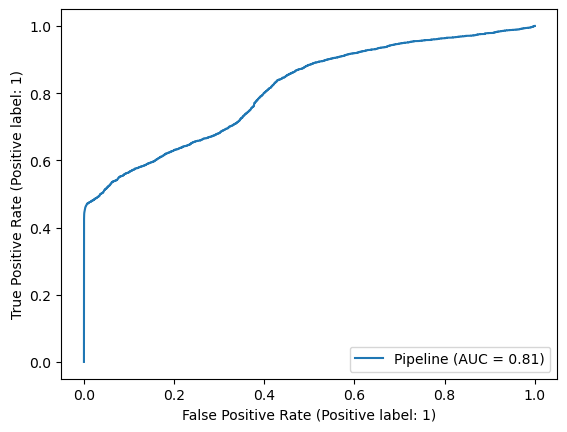

In [11]:
RocCurveDisplay.from_estimator(model, X_test, y_test);

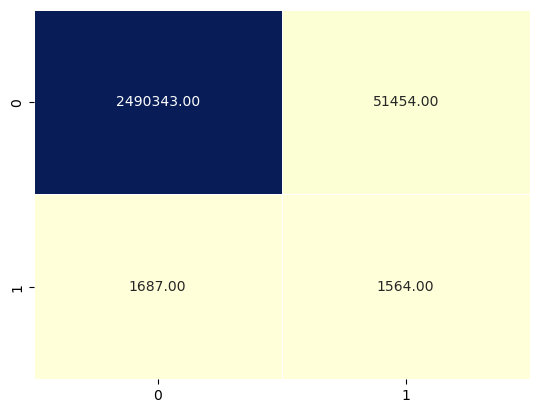

In [16]:
y_preds = model.predict(X_test)
cm = confusion_matrix(y_test, y_preds)
sn.heatmap(cm, annot=True, fmt=".2f", cbar=False, linewidths=0.5, cmap="YlGnBu");

In [13]:
len(y_preds)

2545048

In [14]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99   2541797
           1       0.03      0.48      0.06      3251

    accuracy                           0.98   2545048
   macro avg       0.51      0.73      0.52   2545048
weighted avg       1.00      0.98      0.99   2545048



In [39]:
len(df.isFraud[df.isFraud == 1])

8213

In [43]:
len(df.isFlaggedFraud[df.isFlaggedFraud == 1])

16